### Example 1 (FBP and Fourier)

#### This example shows how to use methods from the HTTomolibgpy library to do the following:
* normalise the data 
* calculate the centre of rotation using Vo Centering method
* reconstruct using the FBP and Fourier algorithms

____! CCPi-regularisation package (CuPy part needed only) is missing, please install !____
The shape of the data is (180, 128, 160) as (projections, detector Y, detector X)
Normalising the data


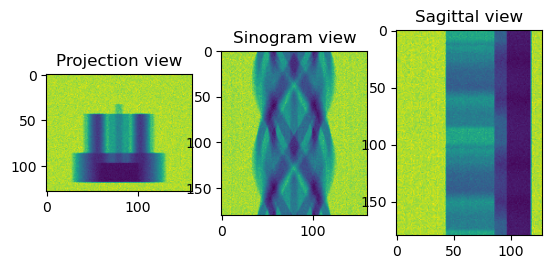

In [1]:
import os
import numpy as np
import cupy as cp
import httomolibgpu
import matplotlib.pyplot as plt
from httomolibgpu.prep.normalize import normalize

# Load the projection data
path_lib = os.path.dirname(httomolibgpu.__file__)
in_file = os.path.abspath(
    os.path.join(path_lib, "..", "tests/test_data/", "tomo_standard.npz")
)
datafile = np.load(in_file)
host_data = datafile["data"]
host_flats = datafile["flats"]
host_darks = datafile["darks"]

print(
    "The shape of the data is {} as (projections, detector Y, detector X)".format(
        np.shape(host_data)
    )
)

print("Normalising the data")
data = cp.asarray(host_data)
flats = cp.asarray(host_flats)
darks = cp.asarray(host_darks)
data_normalised = normalize(data, flats, darks, cutoff=10, minus_log=False)

sliceSel = 64
data_normalised_np = data_normalised.get()

plt.figure()
plt.subplot(131)
plt.imshow(data_normalised_np[sliceSel, :, :])
plt.title("Projection view")

plt.subplot(132)
plt.imshow(data_normalised_np[:, sliceSel, :])
plt.title("Sinogram view")

plt.subplot(133)
plt.imshow(data_normalised_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()

In [2]:
from httomolibgpu.recon.rotation import find_center_vo

print("Finding the Center of Rotation for the reconstruction")
cor = find_center_vo(data_normalised, ind=64)
print("The found Center of Rotation is {}".format(cor))

Finding the Center of Rotation for the reconstruction
The found Center of Rotation is 79.5


134


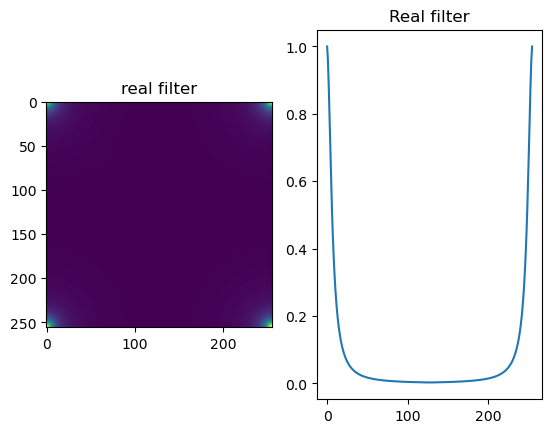

In [38]:
from httomolibgpu.prep.phase import paganin_filter_tomopy

# from httomolibgpu.prep.phase import _paganin_filter_factor2, _calculate_pad_size, _reciprocal_grid
# from cupyx.scipy.fft import fftshift, ifftshift

# Compute the reciprocal grid.
# w2 = _reciprocal_grid(pixel_size, (padded_shape_dy, padded_shape_dx))

# phase_filter = _paganin_filter_factor2(energy, dist, alpha, w2).get()
# phase_filter = ifftshift(fftshift(_paganin_filter_factor2(energy, dist, alpha, w2)))
# phase_filter = phase_filter / phase_filter.max()  # normalisation
# phase_filter = phase_filter.get()


# print(full_size_kernel)
# plt.figure()
# plt.imshow(phase_filter)
# plt.figure()
# plt.imshow(w2.get())
# print(np.max(curve1D))
# plt.figure()
# plt.imshow(phase_filter)
# plt.figure()
# plt.plot(curve1D)


import numpy as np
import math
from scipy.fft import fftshift, ifftshift


def _calculate_pad_size(datashape: tuple) -> list:
    pad_list = []
    for index, element in enumerate(datashape):
        if index == 0:
            pad_width = (0, 0)  # do not pad the slicing dim
        else:
            diff = _shift_bit_length(element + 1) - element
            if element % 2 == 0:
                pad_width_scalar = diff // 2
                pad_width = (pad_width_scalar, pad_width_scalar)
            else:
                # need an uneven padding for odd-number lengths
                left_pad = diff // 2
                right_pad = diff - left_pad
                pad_width = (left_pad, right_pad)

        pad_list.append(pad_width)

    return pad_list


def _shift_bit_length(x: int) -> int:
    return 1 << (x - 1).bit_length()


def _wavelength(energy):
    return 2 * PI * PLANCK_CONSTANT * SPEED_OF_LIGHT / energy


def _paganin_filter_factor(energy, dist, alpha, w2):
    return 1 / (_wavelength(energy) * dist * w2 / (4 * PI) + alpha)


def _reciprocal_coord(pixel_size: float, num_grid: int) -> cp.ndarray:
    n = num_grid - 1
    rc = np.arange(-n, num_grid, 2, dtype=cp.float32)
    rc *= 2 * math.pi / (n * pixel_size)
    return rc


def _reciprocal_grid(pixel_size, nx, ny):
    # Sampling in reciprocal space.
    indx = _reciprocal_coord(pixel_size, nx)
    indy = _reciprocal_coord(pixel_size, ny)
    np.square(indx, out=indx)
    np.square(indy, out=indy)
    return np.add.outer(indx, indy)


pixel_size = 0.0001
dist = 50
energy = 53
alpha = 0.1
datashape = cp.shape(data_normalised)

pad_list = _calculate_pad_size(datashape)
padded_shape_dy = datashape[1] + pad_list[1][0] + pad_list[1][1]
padded_shape_dx = datashape[2] + pad_list[2][0] + pad_list[2][1]

BOLTZMANN_CONSTANT = 1.3806488e-16  # [erg/k]
SPEED_OF_LIGHT = 299792458e2  # [cm/s]
PI = 3.14159265359
PLANCK_CONSTANT = 6.58211928e-19  # [keV*s]

w2 = _reciprocal_grid(pixel_size, padded_shape_dy, padded_shape_dx)

phase_filter = ifftshift(_paganin_filter_factor(energy, dist, alpha, w2))
phase_filter = phase_filter / phase_filter.max()  # normalisation


cutoff = 1e-2

curve1D = np.abs(phase_filter[0, :])
half_width_kernel = np.argmax(curve1D < cutoff)
full_size_kernel = 2 * half_width_kernel
print(full_size_kernel)

plt.figure()
plt.subplot(121)
plt.imshow(phase_filter)
plt.title("real filter")

plt.subplot(122)
plt.plot(curve1D)
plt.title("Real filter")
plt.show()


# def _reciprocal_coord(pixel_size, num_grid):
#     n = num_grid - 1
#     rc = np.arange(-n, num_grid, 2, dtype = np.float32)
#     rc *= 0.5 / (n * pixel_size)
#     return  rc

# import numpy
#
# lamda = (1.23984193e-9)/energy #for photons: E = 1keV -> 1.23984193 nm
# delta = 1
# beta = 1

# print(delta/beta)

# delta_x = pixel_size/(2*numpy.pi); delta_y = delta_x
# k_x = numpy.fft.fftfreq(padded_shape_dx, d=delta_x)
# k_y = numpy.fft.fftfreq(padded_shape_dy, d=delta_y)
# k_x_grid, k_y_grid = numpy.meshgrid(k_x, k_y)
# k_squared = k_x_grid**2 + k_y_grid**2
# paganinFilter = 1.0 / (1.0 + dist * lamda * delta * k_squared /
#     (4 * numpy.pi * beta))

# plt.figure()
# plt.imshow(ifftshift(paganinFilter))

Applying Paganin filter


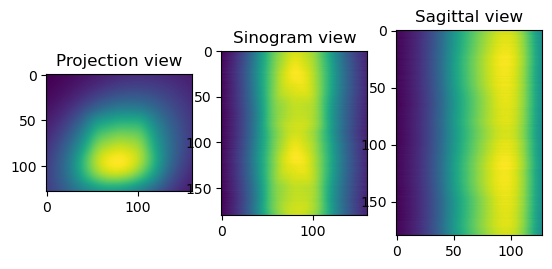

In [42]:
from httomolibgpu.prep.phase import paganin_filter_tomopy

print("Applying Paganin filter")
phase_contrast_data = paganin_filter_tomopy(
    data_normalised, pixel_size=0.0001, dist=50, energy=53, alpha=0.001
)

sliceSel = 64
phase_contrast_data_np = phase_contrast_data.get()

plt.figure()
plt.subplot(131)
plt.imshow(phase_contrast_data_np[sliceSel, :, :])
plt.title("Projection view")

plt.subplot(132)
plt.imshow(phase_contrast_data_np[:, sliceSel, :])
plt.title("Sinogram view")

plt.subplot(133)
plt.imshow(phase_contrast_data_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()

Perform Reconstruction using FBP


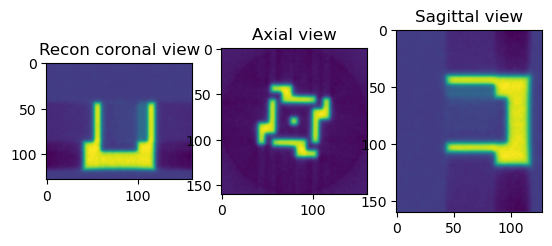

In [15]:
print("Perform Reconstruction using FBP")

from httomolibgpu.recon.algorithm import FBP

angles = np.linspace(0.0 * np.pi / 180.0, 180.0 * np.pi / 180.0, data.shape[0])

reconFBP = FBP(phase_contrast_data, angles=angles, center=cor, filter_freq_cutoff=1.1)

reconFBP_np = reconFBP.get()

sliceSel = 64
plt.figure()
plt.subplot(131)
plt.imshow(reconFBP_np[sliceSel, :, :])
plt.title("Recon coronal view")

plt.subplot(132)
plt.imshow(reconFBP_np[:, sliceSel, :])
plt.title("Axial view")

plt.subplot(133)
plt.imshow(reconFBP_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()

Perform Reconstruction using Fourier (LPRec)


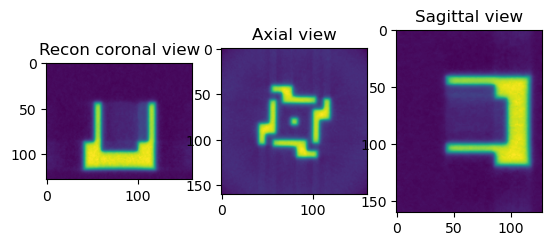

In [16]:
print("Perform Reconstruction using Fourier (LPRec)")

from httomolibgpu.recon.algorithm import LPRec

angles = np.linspace(0.0 * np.pi / 180.0, 180.0 * np.pi / 180.0, data.shape[0])

reconLPRec = LPRec(phase_contrast_data, angles=angles, center=cor)

reconLPRec_np = reconLPRec.get()

sliceSel = 64
plt.figure()
plt.subplot(131)
plt.imshow(reconLPRec_np[sliceSel, :, :])
plt.title("Recon coronal view")

plt.subplot(132)
plt.imshow(reconLPRec_np[:, sliceSel, :])
plt.title("Axial view")

plt.subplot(133)
plt.imshow(reconLPRec_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()